# Comparing Shap values between high and low thrombolysing hospitals

## Plain English summary

It has become apparent that hospitals are making different clinical decisions, and that it is not just the patient group that is accounting for the difference in thrombolysis rates between hosptials. For example, hospitals presented with the same information can make opposing decisions on whether or not to give a patient thrombolysis. We would like to pick apart what factors different hospitals are using to make their different decisions. Here we create two groups of hospitals: those that have a high propensity to thrombolyse, and those that have a low propensity to thrombolyse. By comparing the SHAP values for a specific feature between these two hospital groups shows the contribution this feature is having on their different decision of whether to give thrombolysis.

We see that low and high thrombolysing hosptials have the same general pattern, that a patient is more likely to recieve thromboylsis if they have a mid-level stroke severity. But it can be seen that the more cautious hospitals are even less likely to thrombolyse mild and severe strokes, are more likely to thrombolyse mid-level strokes. The wider the net for including hospitals into the two groups (9 vs 30) the less pronounced the difference.

## Model and data

The necessary data for this analysis was created in previous notebooks (that trained the models): feature data, SHAP values.

The XGBoost model is fitted to 10 features:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 8 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

The Python library SHAP was applied to the first k-fold model to obtain a SHAP value for each feature, for each instance. SHAP values are in the same units as the model output, so for XGBoost this is in log odds-ratio.

A single SHAP value per feature was obtained by taking the mean of the absolute values across all instances.

## A note on Shap values

Shap values are usually reported as *log odds shifts* in model predictions. For a description of the relationships between probability, odds, and Shap values (log odds shifts) see [here](../introduction/odds_prob.md).

## Aims:

* Identify top 30 and bottom 30 hosptials judged by the 10k cohort dataset
* Plot SHAP values for the feature stroke severity (NIHSS) for the top and bottom hospitals
* Represent the data for the patients that did, and did not, receive thrombolysis
* Repeat for top and bottom 9 hospitals
* Repeat for feature prior disability (mRS)

## Observations

* Low and high thrombolysing hosptials have the same general pattern: that a patient is more likely to recieve thromboylsis if they have a mid-level stroke severity. This is overlaid over different hospital SHAP values.
* There is an average diffeence in hospital SHAP of 1.31 between the top and bottom 30 hospitals, and 1.98 between the top and bottom 9 hospitals. These differences are equivalent to a difference in odds of receiving thrombolysis of 3.7 and 7.2 respectiviely.
* Lower thrombolysing hospitals have a more exagerrated effect of stroke severity, though other features such as disability before stroke, use of AF anticoagulants and arrival to scan time look similar.

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import shap

from xgboost import XGBClassifier

import json

## Set filenames

In [2]:
number_key_features = 10
model_text = f'xgb_{number_key_features}_features'
notebook = '08'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file
Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

### Load data on predicted 10k cohort thrombolysis use at each hospital
Use the hospitals thrombolysis rate on the same set of 10k patients to select the 30 hospitals with the highest thrombolysis rates.

In [5]:
thrombolysis_by_hosp = pd.read_csv(
    f'./output/04_{model_text}_10k_thrombolysis_rate_by_hosp.csv', 
    index_col='stroke_team')
thrombolysis_by_hosp.sort_values(
    'Thrombolysis rate', ascending=False, inplace=True)

In [6]:
thrombolysis_by_hosp.head()

,Thrombolysis rate
stroke_team,
VKKDD9172T,0.4527
GKONI0110I,0.4132
HPWIF9956L,0.4131
CNBGF2713O,0.4093
TPXYE0168D,0.3962


Use the hospitals thrombolysis rate on the same set of 10k patients to select the 30 hospitals with the highest thrombolysis rates.

In [7]:
top_30_hospitals = list(thrombolysis_by_hosp.head(30).index)
bottom_30_hospitals = list(thrombolysis_by_hosp.tail(30).index)

## Load SHAP data for first k-fold model
Use explainer to access the feature names (explainer.data_feature_names) and shap_values_extended to access the data values and SHAP values

In [8]:
k = 0
filename = f'./output/03_{model_text}_shap_values_extended_{k}.p'
with open(filename, 'rb') as filehandler:
    shap_values_extended = pickle.load(filehandler)
    
filename = f'./output/03_{model_text}_shap_values_explainer_{k}.p'
with open(filename, 'rb') as filehandler:
    explainer = pickle.load(filehandler)

## Load target feature data for first k-fold model

In [9]:
data_loc = '../data/kfold_5fold/'
feature = 'S2Thrombolysis'

test = pd.read_csv(data_loc + 'test_0.csv')
target_feature = test[feature]

## Prepare the datasets
Create Dataframe containing the feature values and target value (with feature names as column titles)

In [10]:
df_data_values = pd.DataFrame(shap_values_extended.data)
df_data_values.columns = explainer.data_feature_names
df_data_values = df_data_values.join(target_feature)
df_data_values

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,team_AGNOF1041H,...,team_XPABC1435F,team_XQAGA4299B,team_XWUBX0795L,team_YEXCH8391J,team_YPKYH1768F,team_YQMZV4284N,team_ZBVSO0975W,team_ZHCLE1578P,team_ZRRCV7012C,S2Thrombolysis
0,17.0,1.0,14.0,1.0,0.0,0.0,186.0,0.0,47.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,25.0,1.0,6.0,1.0,0.0,0.0,71.0,0.0,52.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,138.0,1.0,2.0,1.0,0.0,0.0,67.0,0.0,42.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,21.0,0.0,11.0,1.0,0.0,0.0,86.0,0.0,77.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,8.0,1.0,16.0,1.0,0.0,0.0,83.0,0.0,77.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17754,8.0,1.0,4.0,1.0,0.0,0.0,105.0,0.0,77.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
17755,35.0,1.0,25.0,0.0,3.0,0.0,208.0,0.0,92.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
17756,80.0,1.0,2.0,0.0,1.0,0.0,236.0,0.0,87.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
17757,16.0,1.0,10.0,1.0,0.0,0.0,34.0,0.0,77.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Create Dataframe containing the SHAP values (with feature names as column titles)

In [11]:
df_shap_values = pd.DataFrame(shap_values_extended.values)
df_shap_values.columns = explainer.data_feature_names
df_shap_values

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,team_AGNOF1041H,...,team_XKAWN3771U,team_XPABC1435F,team_XQAGA4299B,team_XWUBX0795L,team_YEXCH8391J,team_YPKYH1768F,team_YQMZV4284N,team_ZBVSO0975W,team_ZHCLE1578P,team_ZRRCV7012C
0,1.644524,1.781234,1.512816,0.475095,0.510118,0.231340,0.027640,0.044822,0.432631,0.013371,...,0.0,0.0,0.010519,0.0,0.0,0.0,0.0,0.0,-0.000230,0.011267
1,0.950944,1.667179,0.711063,0.483554,0.501495,0.276194,-0.107594,0.049120,0.250526,-0.005134,...,0.0,0.0,0.010519,0.0,0.0,0.0,0.0,0.0,-0.002508,0.015604
2,-0.824374,1.305925,-1.474893,0.383569,0.332808,0.148269,0.348699,0.055192,0.700821,0.007675,...,0.0,0.0,0.006107,0.0,0.0,0.0,0.0,0.0,-0.002508,0.008730
3,0.538693,-7.683888,0.710589,0.242471,0.238568,0.119916,0.073929,0.026681,0.036322,-0.005134,...,0.0,0.0,0.007752,0.0,0.0,0.0,0.0,0.0,-0.009263,0.005612
4,1.535579,1.795330,1.447147,0.478955,0.432387,0.232291,0.086951,0.053770,0.059884,0.010152,...,0.0,0.0,0.007752,0.0,0.0,0.0,0.0,0.0,-0.001763,0.006505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17754,1.420294,1.655126,0.162147,0.687616,0.482946,0.203699,0.236643,0.049837,0.140686,0.004882,...,0.0,0.0,0.007752,0.0,0.0,0.0,0.0,0.0,0.000538,0.001721
17755,0.740244,1.428696,1.173393,-0.909235,-0.182740,0.140341,-1.109779,0.060577,-0.421742,0.000066,...,0.0,0.0,0.007752,0.0,0.0,0.0,0.0,0.0,-0.004750,0.014527
17756,-0.903385,1.158949,-0.993160,-0.604351,-0.052663,0.224581,-2.460304,0.056280,-0.539638,0.004968,...,0.0,0.0,0.012421,0.0,0.0,0.0,0.0,0.0,-0.003623,0.007151
17757,1.397310,1.784579,1.182772,0.506637,0.445145,0.229859,0.403365,0.053431,0.109485,0.015127,...,0.0,0.0,0.007752,0.0,0.0,0.0,0.0,0.0,-0.008382,0.006821


## Boxplot showing the average SHAP value for the top 30 hospitals, and the bottom 30 hospitals

For each group of hospitals (1. top 30 hospitals, and 2. bottom 30 hospitals - as defined by their IVT rate for the 10k patient cohort) show the range of average SHAP values for those instances that attend the hospital.

In [12]:
# List of the top 30 hospital feature names
top_30_hospital_names = ["team_" + h for h in top_30_hospitals]
    
# Initiate list for average SHAP values (one per top 30 hospital) for
#   instances that attend that stroke team
top_30_hosp_ave = []

# Through top hospitals
for h in top_30_hospital_names:
    # Calculate and store average SHAP value for each hospital
    mask = df_data_values[h] == 1
    top_30_hosp_ave.append(df_shap_values[h][mask].mean())
    
# Repeat for bottom 30 hosptials
# List of the bottom 30 hospital feature names
bottom_30_hospital_names = ["team_" + h for h in bottom_30_hospitals]

# Initiate list for average SHAP values (one per bottom 30 hospital) for
#   instances that attend that stroke team
bottom_30_hosp_ave = []

# Through bottom hospitals
for h in bottom_30_hospital_names:
    # Calculate and store average SHAP value for each hospital
    mask = df_data_values[h] == 1
    bottom_30_hosp_ave.append(df_shap_values[h][mask].mean())

boxplot_data = [top_30_hosp_ave,
                bottom_30_hosp_ave]

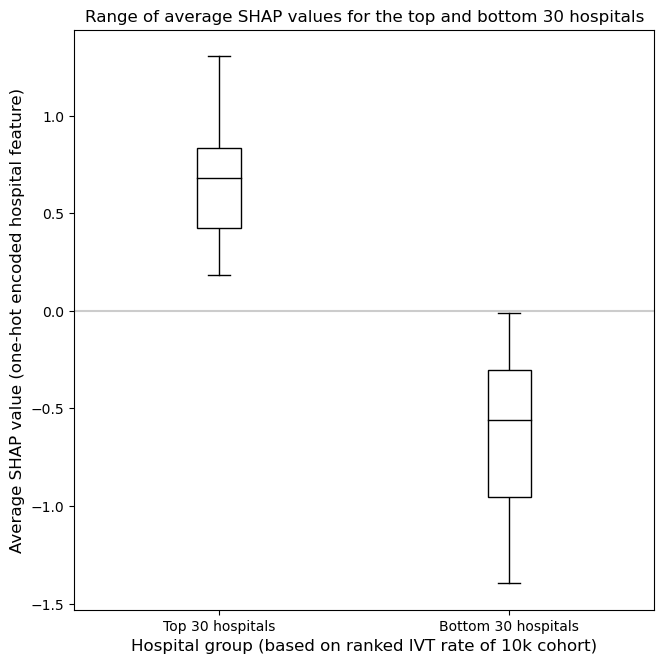

In [13]:
# Create figure with 1 subplot
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

c1 = "black"
c2 = "black"
c3 = "white"
ax.boxplot(boxplot_data,
           labels=["Top 30 hospitals","Bottom 30 hospitals"],
           whis=9999999, patch_artist=True, notch=False,
           boxprops=dict(facecolor=c3, color=c1),
           capprops=dict(color=c1),
           whiskerprops=dict(color=c1),
           flierprops=dict(color=c1, markeredgecolor=c1),
           medianprops=dict(color=c2))

plt.ylabel('Average SHAP value (one-hot encoded hospital feature)',size=12)
plt.xlabel('Hospital group (based on ranked IVT rate of 10k cohort)',size=12)
plt.title("Range of average SHAP values for the top and bottom 30 hospitals")

# Add line at Shap = 0
plt.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 

plt.subplots_adjust(bottom=0.25, wspace=0.05)
    
plt.tight_layout(pad=2)

plt.savefig(f'./output/{notebook}_{model_text}'
            f'_hosp_shap_top_30_vs_bottom_30_boxplot.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

In [14]:
bottom_q1, bottom_q3 = np.percentile(np.asarray(bottom_30_hosp_ave), [25 ,75])
top_q1, top_q3 = np.percentile(np.asarray(top_30_hosp_ave), [25 ,75])
mean_top = np.mean(np.asarray(top_30_hosp_ave))
mean_bottom = np.mean(np.asarray(bottom_30_hosp_ave))
diff = mean_top - mean_bottom

print(f"The top 30 hospitals have (on average) SHAP values for the one-hot "
      f"encoded hospital feature of between {top_q1.round(2)} to "
      f"{top_q3.round(2)} (interquartile range). Compared to "
      f"{bottom_q1.round(2)} to {bottom_q3.round(2)} for the "
      f"bottom hospitals.")
print ()
print (f'The mean top and bottom SHAP values are {mean_top:0.2f}, and {mean_bottom:0.2f}, a difference of {diff:0.2f}.')

The top 30 hospitals have (on average) SHAP values for the one-hot encoded hospital feature of between 0.42 to 0.84 (interquartile range). Compared to -0.95 to -0.3 for the bottom hospitals.

The mean top and bottom SHAP values are 0.67, and -0.64, a difference of 1.31.


## Plot SHAP values for *stroke severity* for the top and bottom 30 hospitals

Identify the top and bottom 30 hospitals with highest thrombolysis rates for the common set of 10k patients. 
Store their stroke team name.

In [15]:
top_30_hospitals = list(thrombolysis_by_hosp.head(30).index)
bottom_30_hospitals = list(thrombolysis_by_hosp.tail(30).index)

Define the function to plot the SHAP values for stroke severity for the two hospital groups.

In [16]:
def plot_shap_per_hospital_group(feature, top_hospital_list, 
                                 bottom_hospital_list, data_values_df, 
                                 shap_values_df, ax,
                                 thrombolysis_given=-1, legend=True):

    """
    If thrombolysis_given is passed (0 or 1) then use mask to split patients
    based on this. If not given, then -1 is flag to not split
    """
    
    # Calculate data for top n hospitals
    shap_df = pd.DataFrame()
    for hospital in top_hospital_list:
        column_name = f"team_{hospital}"
        mask1 = data_values_df[column_name]!=0
        if thrombolysis_given == -1:
            #-1 is flag to not split on this value, so create a mask all 1
            mask2 = mask1 + ~mask1
        else:
            # split based on thrombolysis_given
            mask2 = data_values_df['S2Thrombolysis'] == thrombolysis_given
        mask = mask1 * mask2
        s1 = pd.Series(shap_values_df[feature][mask], name="shap")
        s2 = pd.Series(data_values_df[feature][mask], name="data")
        df = pd.concat([s1, s2], axis=1)
        shap_df = shap_df.append(df)

    # calculate mean per category
    mean_by_category_top = shap_df.groupby('data').mean()

    # Calculate data for bottom n hospitals
    shap_df = pd.DataFrame()
    for hospital in bottom_hospital_list:
        column_name = f"team_{hospital}"
        mask1 = data_values_df[column_name]!=0
        if thrombolysis_given == -1:
            #-1 is flag to not split on this value, so create a mask all 1
            mask2 = mask1 + ~mask1
        else:
            # split based on thrombolysis_given
            mask2 = data_values_df['S2Thrombolysis'] == thrombolysis_given
        mask = mask1 * mask2
        s1 = pd.Series(shap_values_df[feature][mask], name="shap")
        s2 = pd.Series(data_values_df[feature][mask], name="data")
        df = pd.concat([s1, s2], axis=1)
        shap_df = shap_df.append(df)
            
    # calculate mean per category
    mean_by_category_bottom = shap_df.groupby('data').mean()
        
    # plot means
#    fig = plt.figure(figsize=(6,6))
#    ax1 = fig.add_subplot(111)
    n_hospitals = len(top_hospital_list)
    ax.scatter(mean_by_category_top.index,
                mean_by_category_top['shap'],
                label=f"top {n_hospitals} hospitals")
    n_hospitals = len(bottom_hospital_list)
    ax.scatter(mean_by_category_bottom.index,
                mean_by_category_bottom['shap'],
                label=f"bottom {n_hospitals} hospitals")
    ax.set_xlabel(f'{feature} feature value')
    ax.set_ylabel(f'{feature} SHAP value (mean of patients)')
    ax.grid()
    title = ""
    if thrombolysis_given == 0:
        title = "(not receiving thrombolysis) "
    elif thrombolysis_given == 1:
        title = "(receiving thrombolysis) "
    ax.set_title(f'{feature} SHAP values for patients {title}\nattending a low or ' +
                  f'high thrombolysing hospital')
    if legend:
        ax.legend(loc='upper right', bbox_to_anchor=(1.38, 1))
    return(ax)

Plot the SHAP values for stroke severity for the two hospital groups.

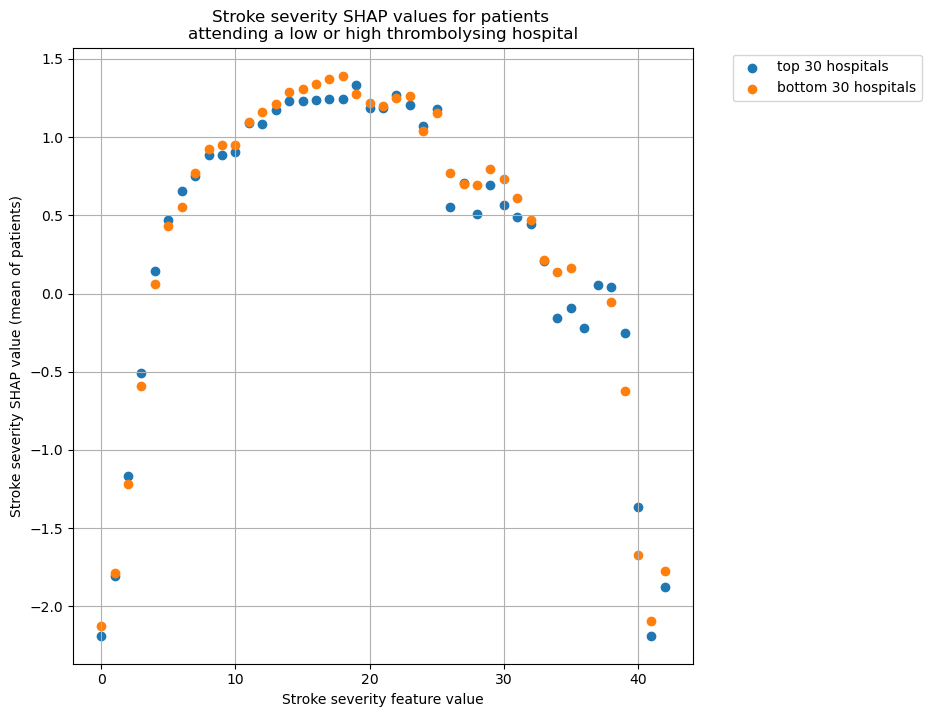

In [17]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(1,1,1)
# Create the plot
ax = plot_shap_per_hospital_group('Stroke severity', top_30_hospitals, 
                                  bottom_30_hospitals, df_data_values, 
                                  df_shap_values, ax)
plt.show()

Plot the SHAP values for stroke severity for the two hospital groups, split the patients by whether received thrombolysis.

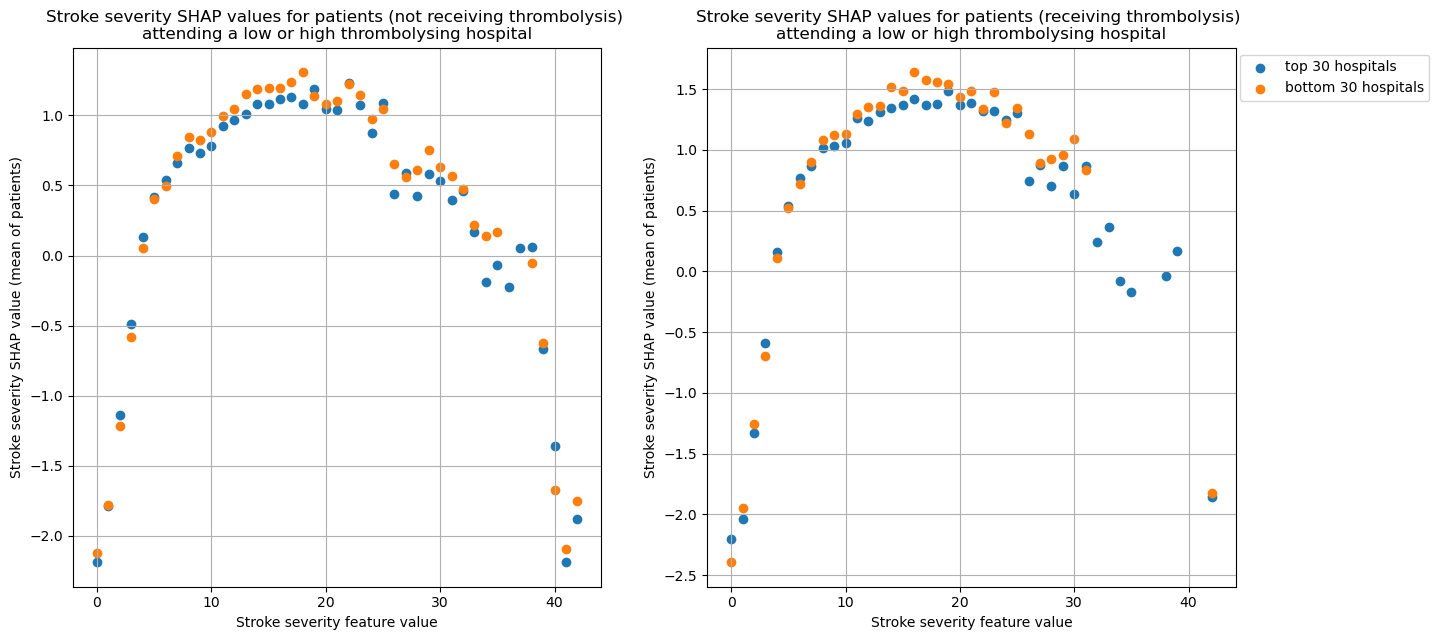

In [18]:
# Set up the two patient populations for the two graphs
thrombolysed = [0,1]

# Create figure
fig = plt.figure(figsize=(15, 7))
subplot = 1
legend = False
# Each each patient population (thrombolysed, and not)
for thrombolysis_given in thrombolysed:
    # Create a subplot
    ax = fig.add_subplot(1,2,subplot)
    # Create the plot
    ax = plot_shap_per_hospital_group('Stroke severity', top_30_hospitals, 
                                      bottom_30_hospitals, df_data_values, 
                                      df_shap_values, ax, legend=legend,
                                      thrombolysis_given=thrombolysis_given)
    legend = True
    subplot += 1

plt.show()

Plot the 30 hosptials individually

In [19]:
def plot_shap_per_hospital(feature, top_hospital_list, 
                           bottom_hospital_list, data_values_df, 
                           shap_values_df,
                           thrombolysis_given=-1):

    title = ""
    if thrombolysis_given == 0:
        title = "(not receiving thrombolysis) "
    elif thrombolysis_given == 1:
        title = "(receiving thrombolysis) "

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    
    n_hospitals = len(bottom_hospital_list)
    ax.set_title(f'{feature} SHAP values for patients \n{title}\nattending ' +
                 f'bottom {n_hospitals} thrombolysing hospital')

    # Calculate data for bottom n hospitals
    for hospital in bottom_hospital_list:
        column_name = f"team_{hospital}"
        mask1 = data_values_df[column_name]!=0
        if thrombolysis_given == -1:
            #-1 is flag to not split on this value, so create a mask all 1
            mask2 = mask1 + ~mask1
        else:
            # split based on thrombolysis_given
            mask2 = data_values_df['S2Thrombolysis'] == thrombolysis_given
        mask = mask1 * mask2
        s1 = pd.Series(shap_values_df[feature][mask], name="shap")
        s2 = pd.Series(data_values_df[feature][mask], name="data")
        df = pd.concat([s1, s2], axis=1)
        plot_hospital_data = df.groupby('data').mean()
        ax.plot(plot_hospital_data.index,
                    plot_hospital_data['shap'],
                    label=hospital)
    #ax.legend(loc='lower center', prop={'size': 8})
    ax.grid()
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('SHAP (mean of patients)')
    ax.set_ylim(-3, 2.5)

    ax = fig.add_subplot(122)
    n_hospitals = len(top_hospital_list)
    ax.set_title(f'{feature} SHAP values for patients \n{title}\nattending ' +
                 f'top {n_hospitals} thrombolysing hospital')

    # Calculate data for top n hospitals
    for hospital in top_hospital_list:
        column_name = f"team_{hospital}"
        mask1 = data_values_df[column_name]!=0
        if thrombolysis_given == -1:
            #-1 is flag to not split on this value, so create a mask all 1
            mask2 = mask1 + ~mask1
        else:
            # split based on thrombolysis_given
            mask2 = data_values_df['S2Thrombolysis'] == thrombolysis_given
        mask = mask1 * mask2
        s1 = pd.Series(shap_values_df[feature][mask], name="shap")
        s2 = pd.Series(data_values_df[feature][mask], name="data")
        df = pd.concat([s1, s2], axis=1)
        plot_hospital_data = df.groupby('data').mean()
        ax.plot(plot_hospital_data.index,
                    plot_hospital_data['shap'],
                    label=hospital)
    #ax.legend(loc='lower center', prop={'size': 8})
    ax.grid()
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('SHAP (mean of patients)')
    ax.set_ylim(-3, 2.5)
    plt.show()

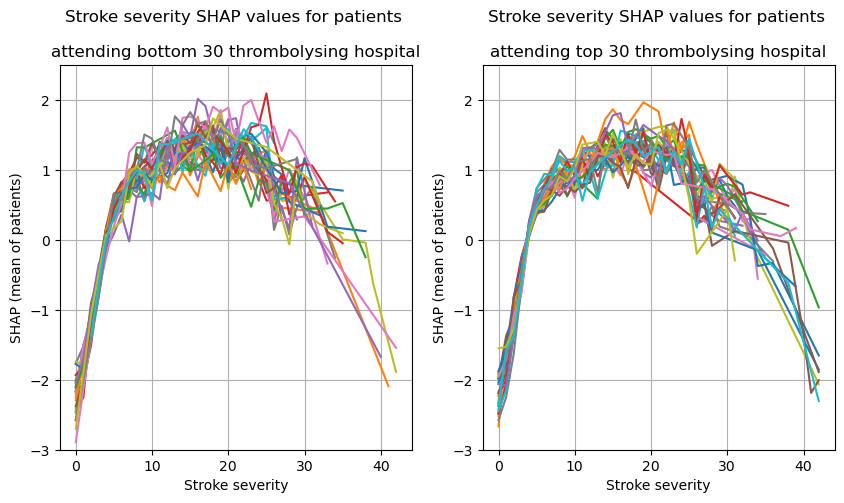

In [20]:
plot_shap_per_hospital('Stroke severity', top_30_hospitals, 
                       bottom_30_hospitals, df_data_values, 
                       df_shap_values)

Plot the 30 hosptials individually, split the patients by whether received thrombolysis.

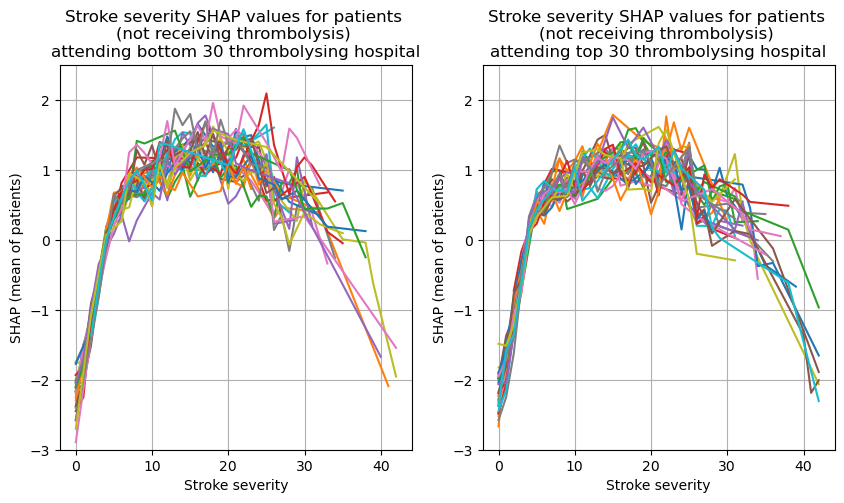

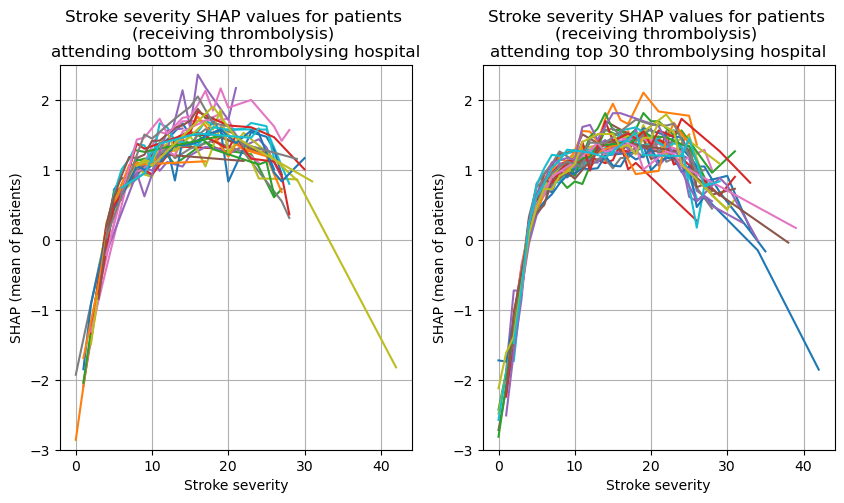

In [21]:
thrombolysed = [0,1]

for thrombolysis_given in thrombolysed:
    plot_shap_per_hospital('Stroke severity', top_30_hospitals, 
                           bottom_30_hospitals, df_data_values, 
                           df_shap_values,
                           thrombolysis_given=thrombolysis_given)

## Repeat for groups with 9 hospitals

In [22]:
top_9_hospitals = list(thrombolysis_by_hosp.head(9).index)
bottom_9_hospitals = list(thrombolysis_by_hosp.tail(9).index)

In [23]:
# List of the top 30 hospital feature names
top_9_hospital_names = ["team_" + h for h in top_9_hospitals]
    
# Initiate list for average SHAP values (one per top 9 hospital) for
#   instances that attend that stroke team
top_9_hosp_ave = []

# Through top hospitals
for h in top_9_hospital_names:
    # Calculate and store average SHAP value for each hospital
    mask = df_data_values[h] == 1
    top_9_hosp_ave.append(df_shap_values[h][mask].mean())
    
# Repeat for bottom 9 hosptials
# List of the bottom 9 hospital feature names
bottom_9_hospital_names = ["team_" + h for h in bottom_9_hospitals]

# Initiate list for average SHAP values (one per bottom 9 hospital) for
#   instances that attend that stroke team
bottom_9_hosp_ave = []

# Through bottom hospitals
for h in bottom_9_hospital_names:
    # Calculate and store average SHAP value for each hospital
    mask = df_data_values[h] == 1
    bottom_9_hosp_ave.append(df_shap_values[h][mask].mean())

boxplot_data = [top_9_hosp_ave, bottom_9_hosp_ave]

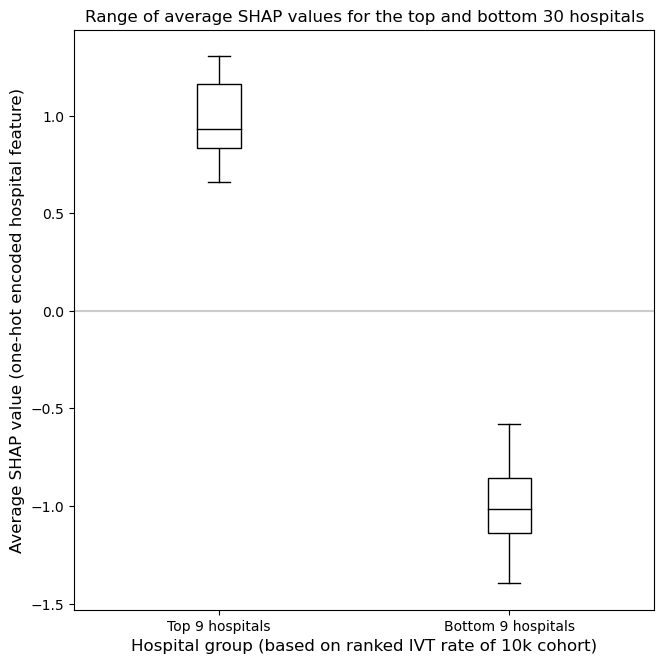

In [24]:
# Create figure with 1 subplot
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

c1 = "black"
c2 = "black"
c3 = "white"
ax.boxplot(boxplot_data,
           labels=["Top 9 hospitals","Bottom 9 hospitals"],
           whis=9999999, patch_artist=True, notch=False,
           boxprops=dict(facecolor=c3, color=c1),
           capprops=dict(color=c1),
           whiskerprops=dict(color=c1),
           flierprops=dict(color=c1, markeredgecolor=c1),
           medianprops=dict(color=c2))

plt.ylabel('Average SHAP value (one-hot encoded hospital feature)',size=12)
plt.xlabel('Hospital group (based on ranked IVT rate of 10k cohort)',size=12)
plt.title("Range of average SHAP values for the top and bottom 30 hospitals")

# Add line at Shap = 0
plt.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 

plt.subplots_adjust(bottom=0.25, wspace=0.05)
    
plt.tight_layout(pad=2)

plt.savefig(f'./output/{notebook}_{model_text}'
            f'_hosp_shap_top_9_vs_bottom_9_boxplot.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

In [25]:
bottom_q1, bottom_q3 = np.percentile(np.asarray(bottom_9_hosp_ave), [25 ,75])
top_q1, top_q3 = np.percentile(np.asarray(top_9_hosp_ave), [25 ,75])
mean_top = np.mean(np.asarray(top_9_hosp_ave))
mean_bottom = np.mean(np.asarray(bottom_9_hosp_ave))
diff = mean_top - mean_bottom

print(f"The top 9 hospitals have (on average) SHAP values for the one-hot "
      f"encoded hospital feature of between {top_q1.round(2)} to "
      f"{top_q3.round(2)} (interquartile range). Compared to "
      f"{bottom_q1.round(2)} to {bottom_q3.round(2)} for the "
      f"bottom hospitals.")
print ()
print (f'The mean top and bottom SHAP values are {mean_top:0.2f}, and {mean_bottom:0.2f}, a difference of {diff:0.2f}.')

The top 9 hospitals have (on average) SHAP values for the one-hot encoded hospital feature of between 0.83 to 1.16 (interquartile range). Compared to -1.14 to -0.86 for the bottom hospitals.

The mean top and bottom SHAP values are 0.97, and -1.01, a difference of 1.98.


Plot the SHAP values for stroke severity for the two hospital groups.

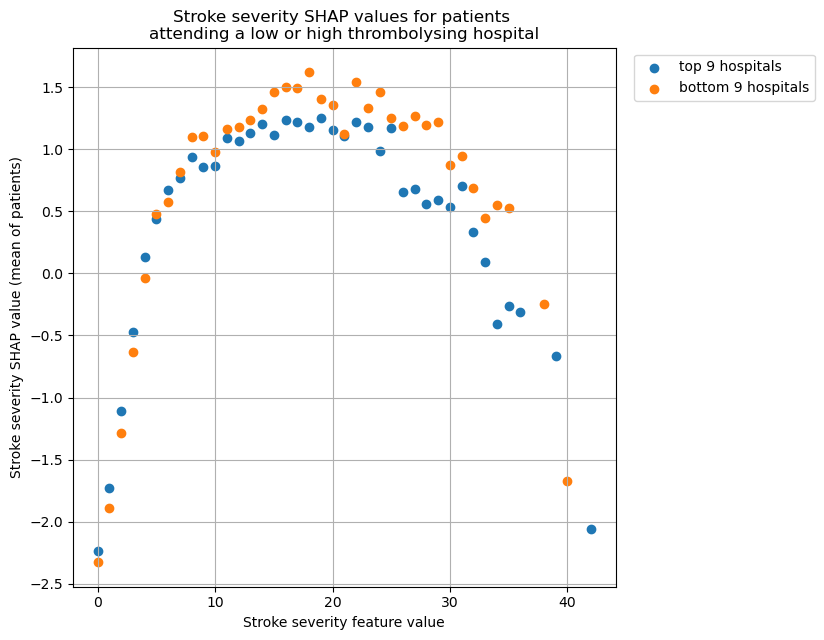

In [26]:
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(1,1,1)
# Create the plot
plot_shap_per_hospital_group('Stroke severity', top_9_hospitals, 
                             bottom_9_hospitals, df_data_values, 
                             df_shap_values, ax)

plt.savefig(f'./output/08_shap_nihss_low_high_thrombolysing_hospitals.jpg', dpi=300)

plt.show()

Plot the SHAP values for stroke severity for the two hospital groups, split the patients by whether received thrombolysis.

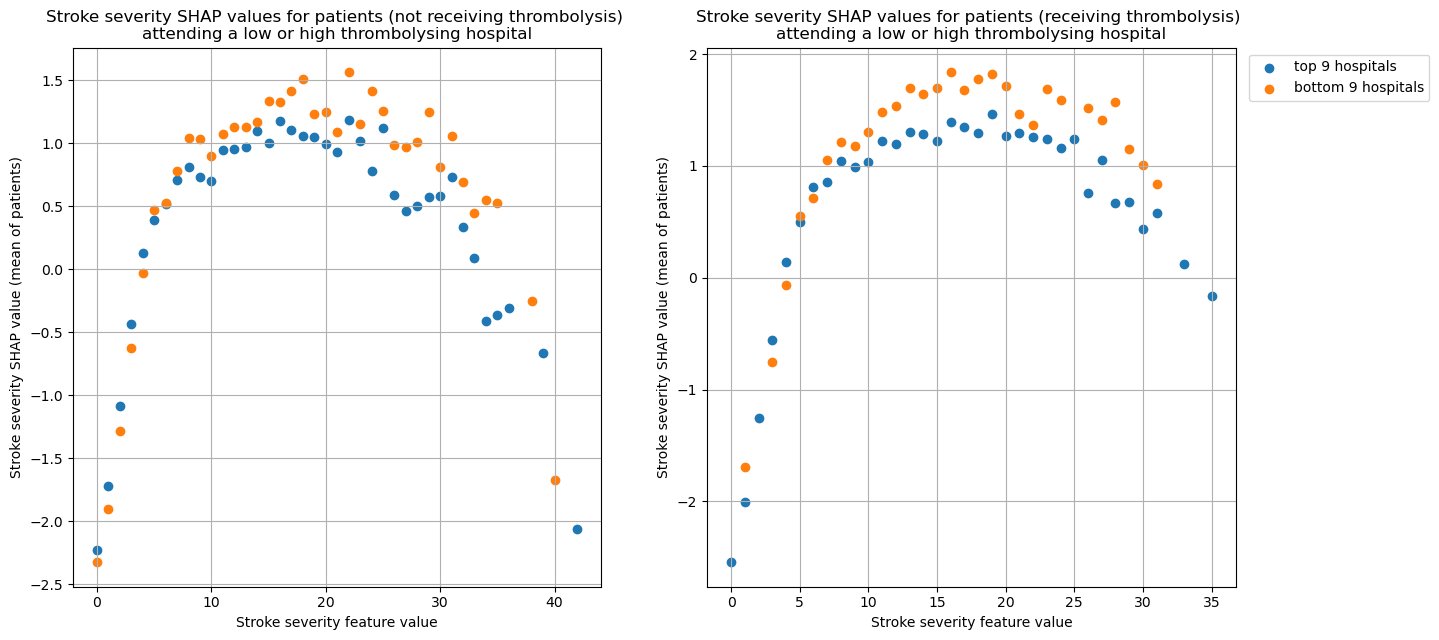

In [27]:
# Set up the two patient populations for the two graphs
thrombolysed = [0,1]

# Create figure
fig = plt.figure(figsize=(15, 7))
subplot = 1

legend = False
# Each each patient population (thrombolysed, and not)
for thrombolysis_given in thrombolysed:
    # Create a subplot
    ax = fig.add_subplot(1,2,subplot)
    # Create the plot
    ax = plot_shap_per_hospital_group('Stroke severity', top_9_hospitals, 
                                      bottom_9_hospitals, df_data_values, 
                                      df_shap_values, ax,
                                      thrombolysis_given=thrombolysis_given,
                                      legend=legend)
    legend = True
    subplot += 1

plt.show()

Plot the 9 hospitals individually

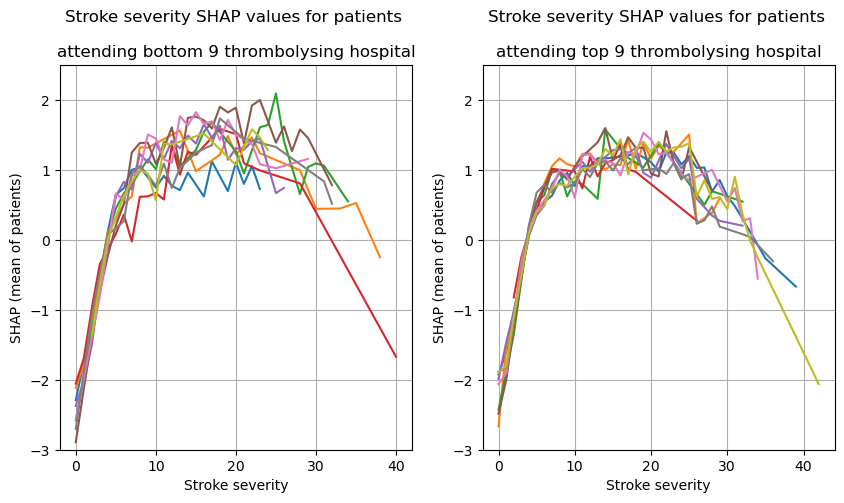

In [28]:
plot_shap_per_hospital('Stroke severity', top_9_hospitals, 
                       bottom_9_hospitals, df_data_values, 
                       df_shap_values)

Plot the 9 hosptials individually, split the patients by whether received thrombolysis.

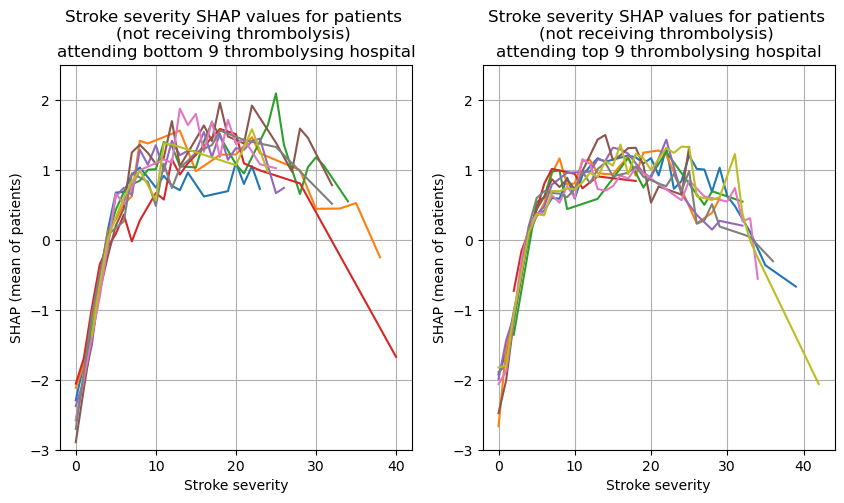

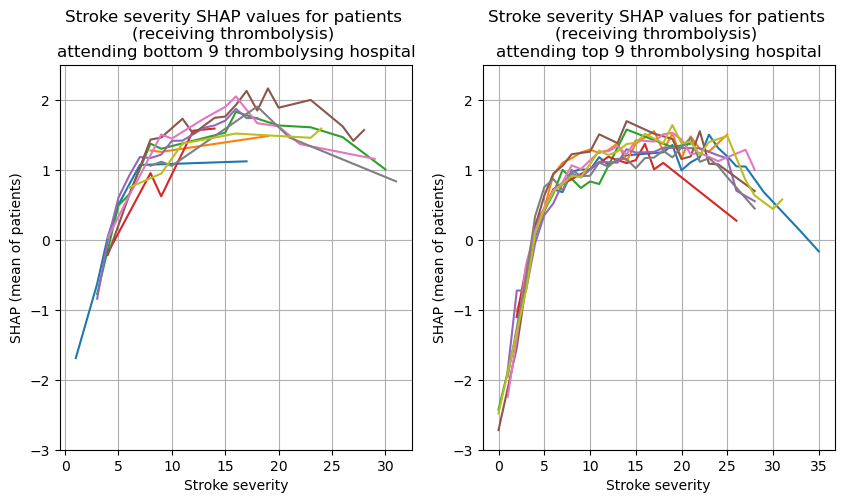

In [29]:
thrombolysed = [0,1]

for thrombolysis_given in thrombolysed:
    plot_shap_per_hospital('Stroke severity', top_9_hospitals, 
                           bottom_9_hospitals, df_data_values, 
                           df_shap_values,
                           thrombolysis_given=thrombolysis_given)

## Plot for *prior disability*

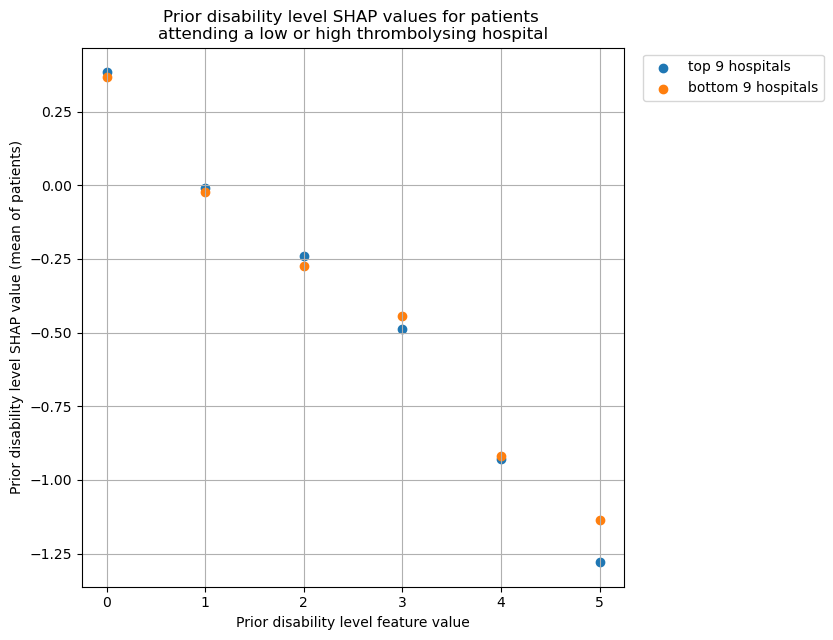

In [30]:
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(1,1,1)
# Create the plot
plot_shap_per_hospital_group('Prior disability level', top_9_hospitals, 
                             bottom_9_hospitals, df_data_values, 
                             df_shap_values, ax)
plt.show()

## Plot for *use of AF anticoagulents*

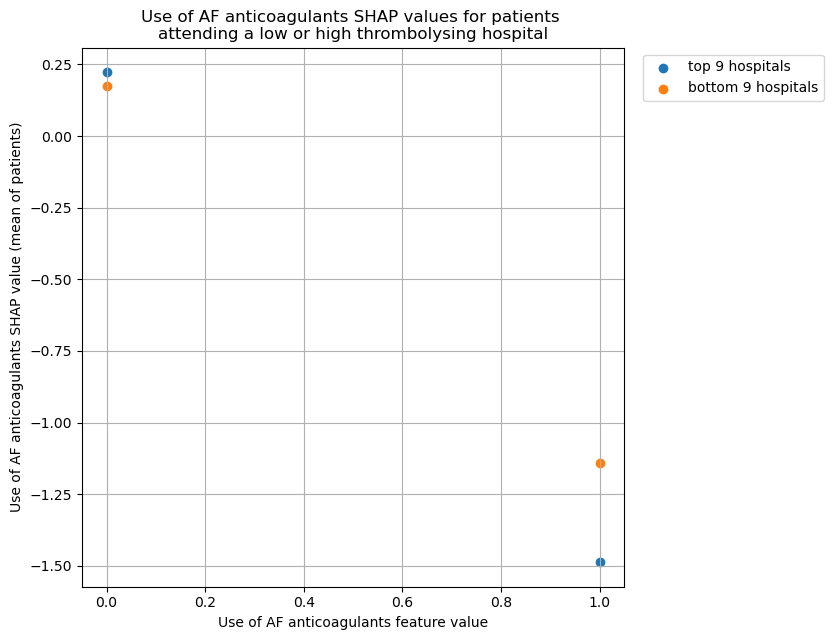

In [31]:
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(1,1,1)
# Create the plot
plot_shap_per_hospital_group('Use of AF anticoagulants', top_9_hospitals, 
                             bottom_9_hospitals, df_data_values, 
                             df_shap_values, ax)
plt.show()

## Plot for *arrival-to-scan time*

(limit the graph to 400 minutes)

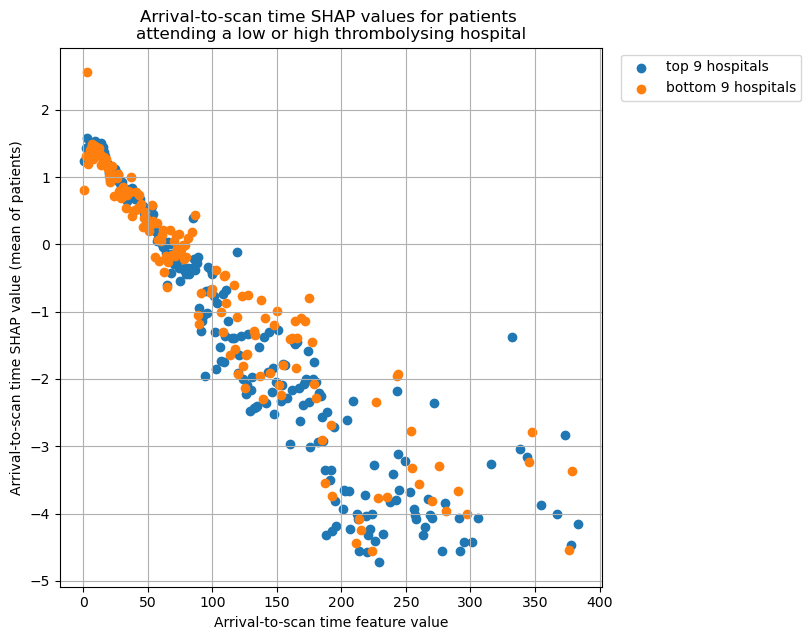

In [32]:
mask = df_data_values['Arrival-to-scan time'] < 400
data_to_plot = df_data_values[mask]
shap_to_plot = df_shap_values[mask]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
# Create the plot
plot_shap_per_hospital_group('Arrival-to-scan time', top_9_hospitals, 
                             bottom_9_hospitals, data_to_plot, 
                             shap_to_plot, ax)
plt.show()